# ESDA, Exploratory Spatial Data Analysis

Exploits the spatial dimension of the data.

Questions to understand better ESDA:
- Is the variable I am looking at concentrated over space? Do similar values tend to locate closeby?
- Can I identify any particular areas where certain values are clustered, concentration of values?
- What is behind this pattern? what could be generating the process?


## Spatial autocorrelation

- Statistical representation of previous sentence (geography)
- Spatial counterpart of traditional correlation (statistics)

Def: Degree to which similar values are located in similar locations

- Positive SA: income, poverty, vegetation, temperature...
- Negative SA: supermarkets, police stations...


We are going to explore three ESDA techniques

1. Global spatial autocorrelation
2. Local spatial autocorrelation
3. Moran plot

In [1]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation
)
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

In [2]:
# Read the file in
br = gpd.read_file(
    "http://darribas.org/gds_course/content/data/brexit.gpkg"
)

In [3]:
br.head()

,objectid,lad16cd,lad16nm,Pct_Leave,geometry
0,1,E06000001,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.27250 54..."
1,2,E06000002,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.23431 54..."
2,3,E06000003,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-1.13717 54.64693, -1.13746 54..."
3,4,E06000004,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-1.31774 54.64524, -1.31869 54..."
4,5,E06000005,Darlington,56.18,"POLYGON ((-1.63799 54.61719, -1.64077 54.61739..."


<Axes: >

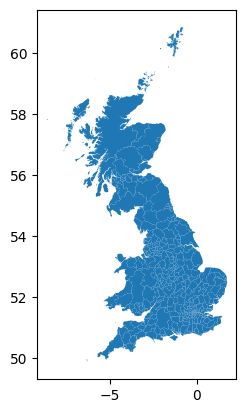

In [4]:
br.plot()

In [5]:
# Index table on the LAD ID
br = br.set_index("lad16cd", drop=False)
# Display summary
br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16cd    380 non-null    object  
 2   lad16nm    380 non-null    object  
 3   Pct_Leave  380 non-null    float64 
 4   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 17.8+ KB


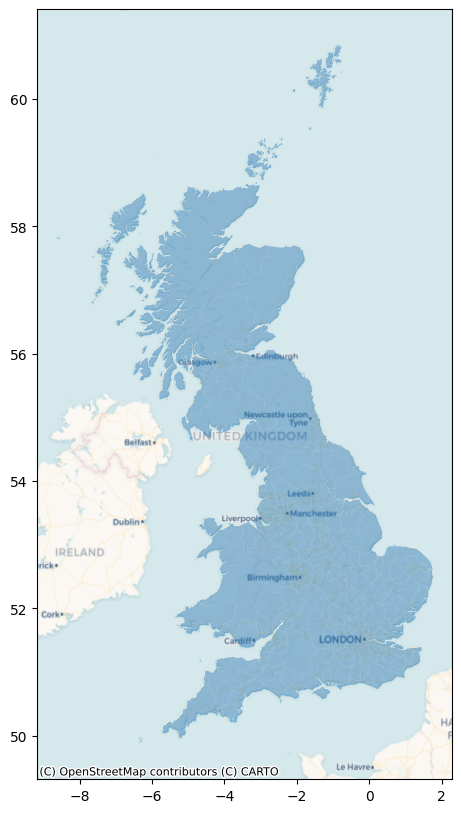

In [6]:
f, ax = plt.subplots(1, figsize=(10, 10))

br.plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax=ax, crs=br.crs, source=ctx.providers.CartoDB.Voyager)

In [7]:
# Create the spatial weights matrix
%time w = weights.Queen.from_dataframe(br, ids='lad16cd')

CPU times: user 2.42 s, sys: 108 ms, total: 2.53 s
Wall time: 2.53 s


/home/pdb/miniconda3/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: E06000046, E06000053, S12000013, S12000023, S12000027, W06000001.
  W.__init__(self, neighbors, ids=ids, **kw)


<Axes: >

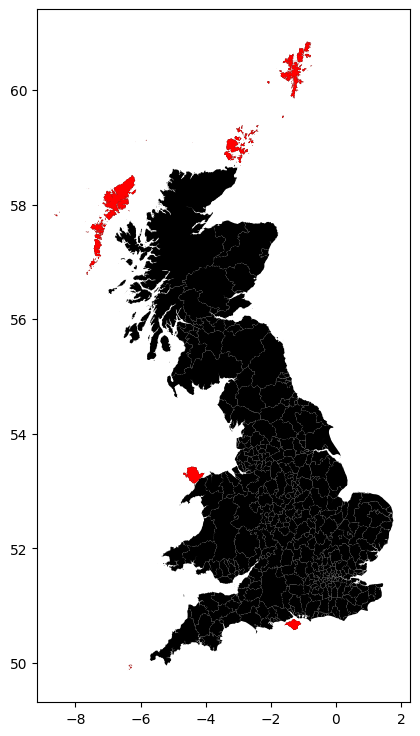

In [8]:
ax = br.plot(color='k', figsize=(9, 9))
br.loc[w.islands].plot(ax=ax, color='r')

In [9]:
# We drop the islands because they could cause issues
br = br.drop(w.islands)

In [10]:
# Create the spatial weights matrix again without islands
%time w = weights.Queen.from_dataframe(br, idVariable="lad16cd")

<timed exec>:1: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.


CPU times: user 1.43 s, sys: 74 ms, total: 1.51 s
Wall time: 1.5 s


<Axes: >

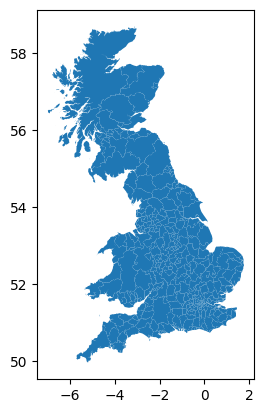

In [11]:
br.plot()

In [12]:
# ROW STANDARDIZE THE MATRIX!!! so the weights of each neighbor will sum one
w.transform = 'R'
w['E06000002']

{'E07000164': 0.3333333333333333,
 'E06000004': 0.3333333333333333,
 'E06000003': 0.3333333333333333}

### Spatial lag (percentage of votes that went to leave the EU)

In [13]:
br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])

Hartlepool, where 69,6% of the electorate voted to leave is surrounded by neighbouring local authorities where, on average, almost 60% of the electorate also voted to leave the EU

In [14]:
br[['lad16cd', 'Pct_Leave', 'w_Pct_Leave']].head()

,lad16cd,Pct_Leave,w_Pct_Leave
lad16cd,,,
E06000001,E06000001,69.57,59.640000
E06000002,E06000002,65.48,60.526667
E06000003,E06000003,66.19,60.376667
E06000004,E06000004,61.73,60.488000
E06000005,E06000005,56.18,57.430000


In [15]:
w.neighbors['E06000001']

['E06000004', 'E06000047']

In [16]:
neis = br.loc[w.neighbors['E06000001'], 'Pct_Leave']
neis

lad16cd
E06000004    61.73
E06000047    57.55
Name: Pct_Leave, dtype: float64

In [17]:
neis.mean() # spatial lag of E06000001: average of variable from neighbors

59.64

In [18]:
# Better to operate with the standardized version (from 0 to 1)
br['Pct_Leave_std'] = (
    br['Pct_Leave'] - br['Pct_Leave'].mean()
) / br['Pct_Leave'].std()

br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])

In [19]:
br[['lad16cd', 'Pct_Leave', 'w_Pct_Leave_std']].head()

,lad16cd,Pct_Leave,w_Pct_Leave_std
lad16cd,,,
E06000001,E06000001,69.57,0.614088
E06000002,E06000002,65.48,0.699170
E06000003,E06000003,66.19,0.684776
E06000004,E06000004,61.73,0.695459
E06000005,E06000005,56.18,0.402023


### Global spatial autocorrelation

About clustering. The overall trend where the distribution of values follows a particular pattern over space:

- Positive: similar values clustered in similar location (high-high and low-low)
- Negative: similar values far from each other (high-low)

**Moran plot**

- Graphical device that displays a variable on the horizontal axis against its spatial lag on the vertical one.
- Variable and spatial weights matrix are preferred standardized.
- We can check the overall association between a variable in a given location and in its neighborhood.

	*Moran's I*: Number that is going to tell us if a map follows a spatial pattern or not.
	- Formal test of global spatial autocorrelation. Statistically identify the presence of clustering in a variable. 
	- Slope of the Moran plot
	- Inference based on how likely it is to obtain a map like observed from a purely random pattern

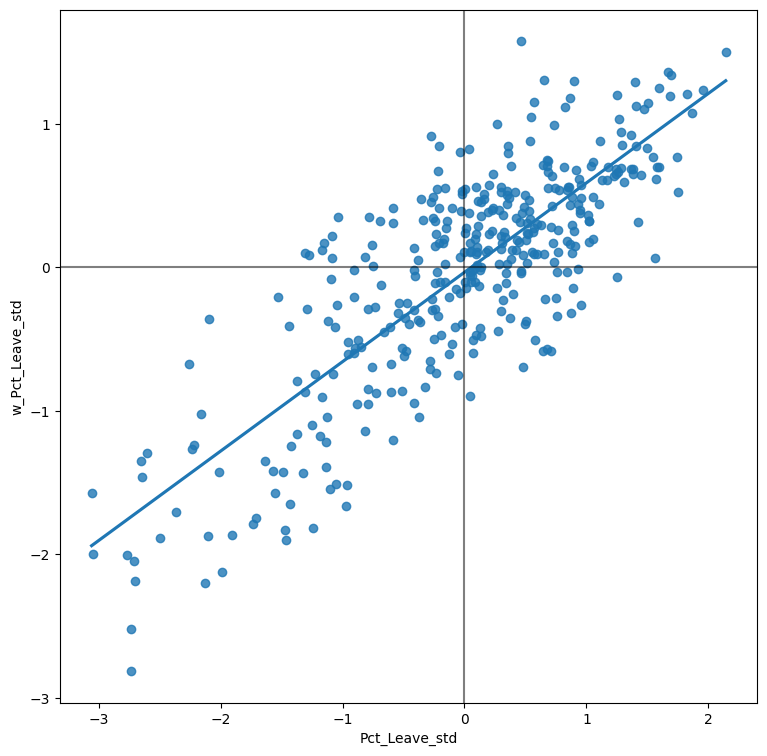

In [20]:
f, ax = plt.subplots(1, figsize=(9, 9))

sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)

plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

plt.show()

In [21]:
mi = esda.Moran(br['Pct_Leave'], w)
mi.I # slope

0.6228641407137806

If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.1% of them would display a larger (absolute) value than the one we obtain from the real data

In [22]:
mi.p_sim

0.001

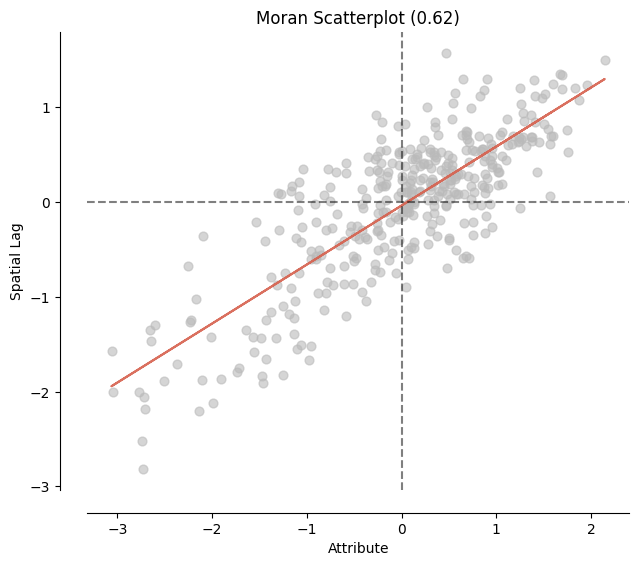

In [23]:
moran_scatterplot(mi);

### Local Spatial autocorrelation

About clusters, pockets of spatial instability.

- High-High class: high values surrounded by high values too (hotspots).
- Low-Low class: low values surrounded by low values (coldspots)
- High-Low: spatial outliers
- Low-High: spatial outliers (donut)

How to measure local correlation? -> LISA

**LISA (Local Indicators of Spatial Association)**

Compares the observed map with many randomly generated ones to see how likely it is to obtain the observed associations for each location.

Given the correlation of all observations, LISA can tell us how is the correlation of each individual cluster in comparison with all the rest.

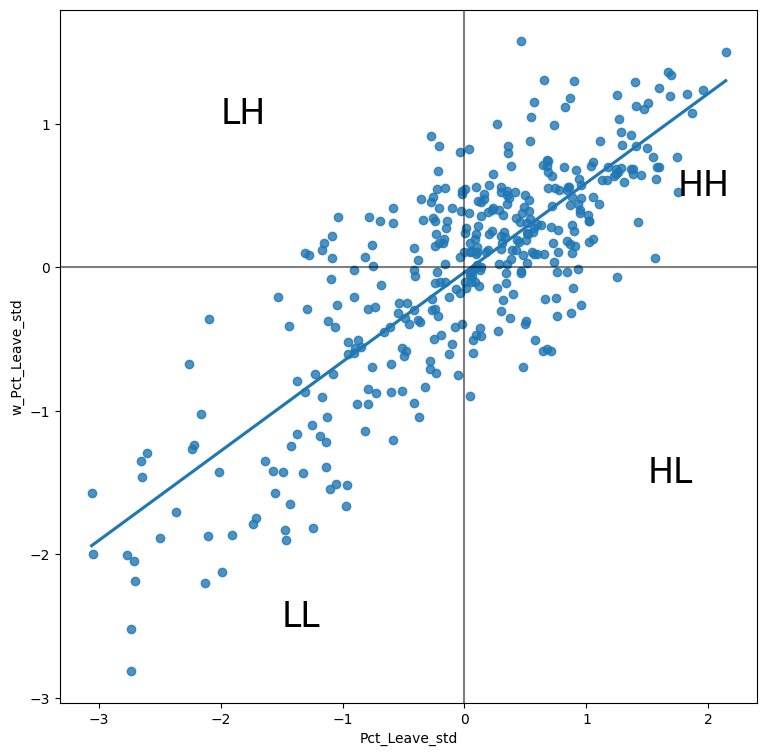

In [24]:
f, ax = plt.subplots(1, figsize=(9, 9))

sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)

plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)

plt.show()

What we are interested in is whether the strength with which the values are concentrated is unusually high. This is exactly what LISAs are designed to do.

The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance.

In [25]:
lisa = esda.Moran_Local(br['Pct_Leave'], w)

In [26]:
# Break observations into significant or not
br['significant'] = lisa.p_sim < 0.05

# Store the quadrant they belong to
br['quadrant'] = lisa.q

- red: high-high
- orange: high-los areas with high leave votes sourranding by areas with low eaving vote
- lighblue: low-high low leaving vote surranding by high leaving vote
- blue: low-low low leaving vote surranding by low leaving vote

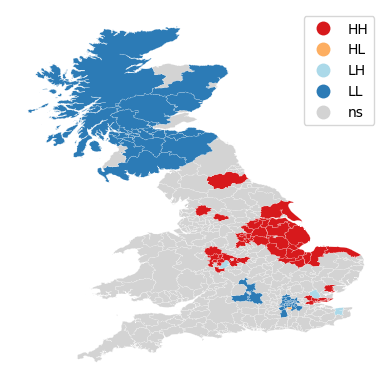

In [27]:
lisa_cluster(lisa, br);

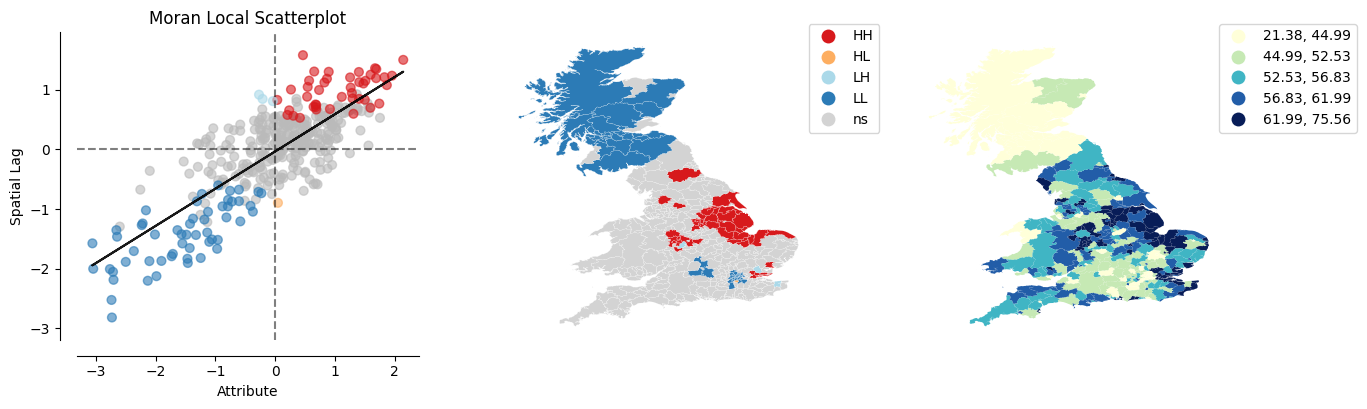

In [28]:
plot_local_autocorrelation(lisa, br, 'Pct_Leave');

<Axes: >

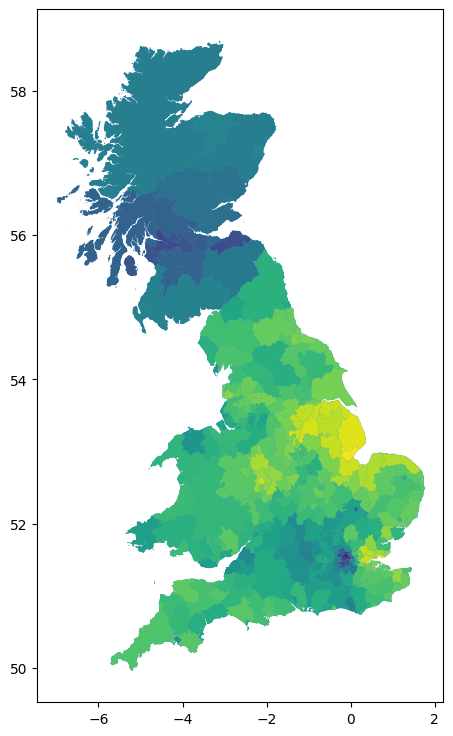

In [30]:
f, ax = plt.subplots(1, figsize=(9, 9))

br.plot(ax=ax)
br.plot(ax=ax, column='w_Pct_Leave_std', cmap='viridis') # spatial lag: w_Pct_Leave_std

# Do-it-Yourself

## Task I: Plot spatial lag of ahah score

In [31]:
ahah_score = pd.read_csv('data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/tables/E08000012.csv')
local_shapes = gpd.read_file("data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/shapefiles/E08000012.shp")

In [32]:
local_shapes.head()

,lsoa11cd,geometry
0,E01006512,"POLYGON ((336103.358 389628.580, 336103.416 38..."
1,E01006513,"POLYGON ((335173.781 389691.538, 335169.798 38..."
2,E01006514,"POLYGON ((335495.676 389697.267, 335495.444 38..."
3,E01006515,"POLYGON ((334953.001 389029.000, 334951.000 38..."
4,E01006518,"POLYGON ((335354.015 388601.947, 335354.000 38..."


In [33]:
ahah_score.head()

,lsoa11cd,lsoa11nm,r_rank,h_rank,g_rank,e_rank,r_exp,h_exp,g_exp,e_exp,...,d_pubs_dist,d_leis_dist,d_blue_dist,d_off_dist,d_tobac_dist,d_green_pas,d_green_act,d_no2_mean,d_pm10_mean,d_so2_mean
0,E01006512,Liverpool 031A,31239,3055,31351,35965,30.888481,1.725173,31.123073,43.744800,...,8,4,9,9,8,9,3,9,4,10
1,E01006513,Liverpool 060A,41456,2213,37636,35878,90.685995,1.236631,50.819353,43.429892,...,10,1,9,10,10,9,8,9,4,10
2,E01006514,Liverpool 037A,37258,4510,39228,35143,49.017998,2.594648,60.485044,40.928662,...,9,2,10,10,9,9,9,9,4,10
3,E01006515,Liverpool 037B,34254,6931,29900,35065,38.227117,4.118458,28.254809,40.678514,...,9,1,10,8,9,9,1,9,4,10
4,E01006518,Liverpool 044A,25433,7533,37244,34392,21.166678,4.513573,48.953916,38.626230,...,5,2,10,7,7,8,8,8,4,10


In [34]:
ahah = pd.merge(local_shapes, ahah_score, on='lsoa11cd')

<Axes: >

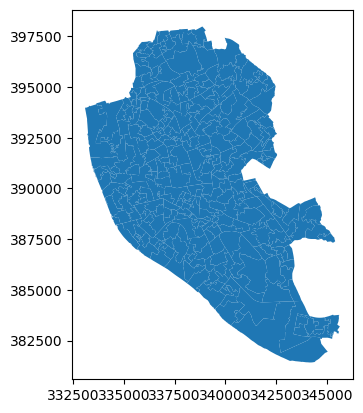

In [35]:
ahah.plot()

In [36]:
w = weights.Queen.from_dataframe(ahah, ids='lsoa11cd')

In [37]:
w.islands

[]

In [38]:
w.transform = 'R'

In [39]:
w['E01006512']

{'E01006679': 0.16666666666666666,
 'E01033757': 0.16666666666666666,
 'E01033768': 0.16666666666666666,
 'E01006751': 0.16666666666666666,
 'E01006513': 0.16666666666666666,
 'E01006673': 0.16666666666666666}

In [43]:
# create standard version of ahah

ahah['ahah_std'] = (
    ahah['ahah'] - ahah['ahah'].mean()
) / ahah['ahah'].std()

In [44]:
# create the spatial lag of the main ahah score

ahah['w_ahah'] = weights.lag_spatial(w, ahah['ahah'])

<Axes: >

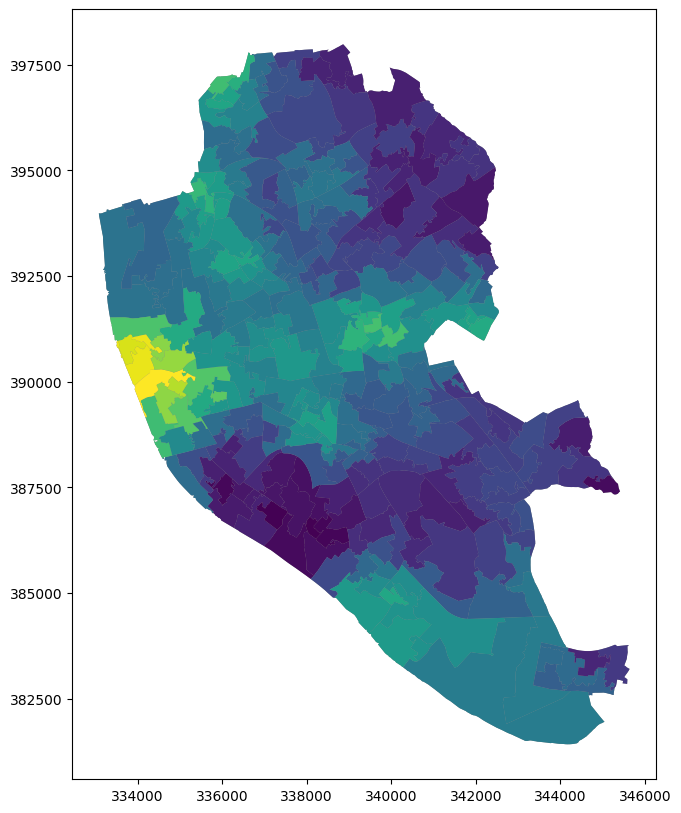

In [45]:
# Visualize spatial lag of ahah score

f, ax = plt.subplots(1, figsize=(10, 10))
ahah.plot(ax=ax, color='k', alpha=0.5)
ahah.plot(ax=ax, cmap='viridis', column='w_ahah')

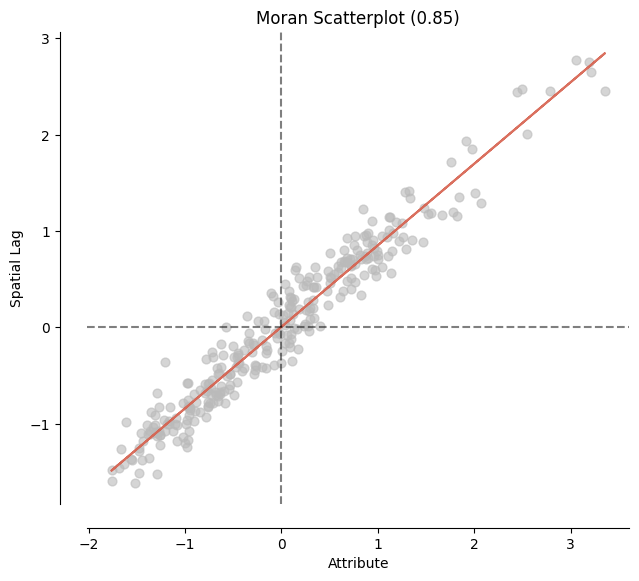

In [46]:
mi = esda.Moran(ahah['w_ahah'], w)
moran_scatterplot(mi);

In [47]:
mi.I # slope

0.8458775385529169

In [48]:
mi.p_sim # below which slope moran will be random

0.001

### Task III: Local spatial autocorrelation

In [49]:
lisa = esda.Moran_Local(ahah['w_ahah'], w)

In [50]:
# Break observations into significant or not
ahah['significant'] = lisa.p_sim < 1

# Store the quadrant they belong to
ahah['quadrant'] = lisa.q

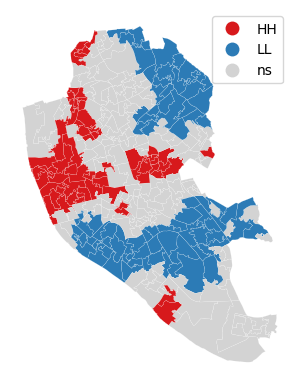

In [51]:
lisa_cluster(lisa, ahah);

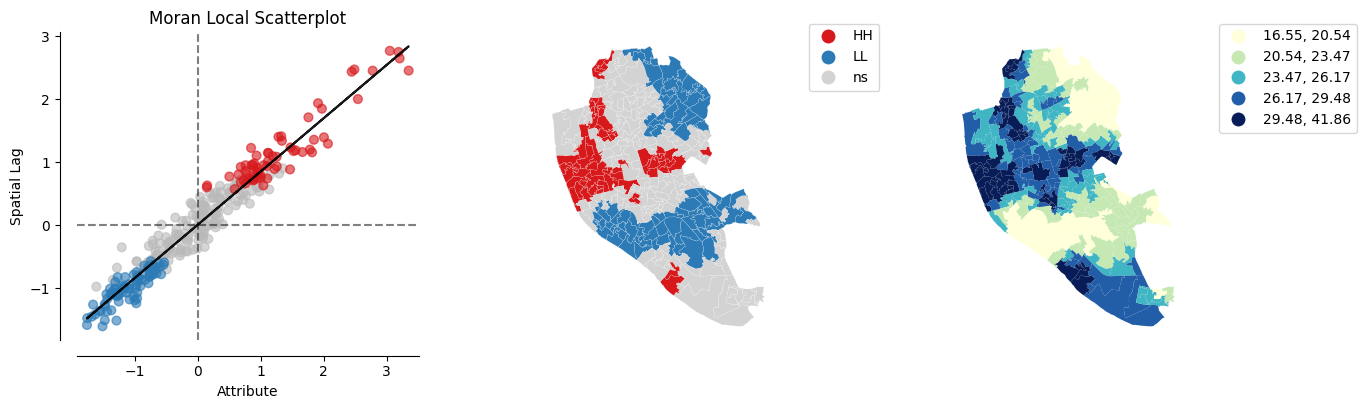

In [52]:
plot_local_autocorrelation(lisa, ahah, 'w_ahah');